In [1]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product

In [2]:
# clf_feat = "catboost_feat00"
# clf_feat = "lgbm_feat01"
# clf_feat = "randomforest_feat02"
# clf_feat = "logisticregression_feat03"
# clf_feat = "tabnet_feat03"

clf_feat = "stacking_catboost_lgbm_randomforest_logisticregression_tabnet"
# clf_feat = "stacking_catboost_lgbm_randomforest_logisticregression"
# clf_feat = "stacking_catboost_lgbm"

train = pl.read_csv("data/train.csv")
oof_pred_df = pl.read_csv(f"pred/oof_pred_{clf_feat}.csv")

test = pl.read_csv(f"data/test.csv").rename({"": "idx"})
test_pred_df = pl.read_csv(f"pred/test_pred_{clf_feat}.csv")

In [3]:
oof_pred_df

health_is_0,health_is_1,health_is_2
f64,f64,f64
0.231069,0.714839,0.054091
0.220525,0.743769,0.035706
0.266093,0.696927,0.03698
0.172648,0.776432,0.050919
0.201574,0.774891,0.023535
0.189254,0.770672,0.040073
0.249449,0.725119,0.025432
0.126436,0.830756,0.042808
0.112779,0.856976,0.030246


In [4]:
test_pred_df

health_is_0,health_is_1,health_is_2
f64,f64,f64
0.179164,0.783609,0.037227
0.118784,0.86317,0.018046
0.207663,0.766755,0.025582
0.12164,0.851875,0.026485
0.214773,0.764522,0.020706
0.170929,0.790277,0.038794
0.094605,0.875518,0.029878
0.163383,0.815579,0.021038
0.240255,0.723933,0.035812


In [5]:
# 正解ラベルの各クラスのデータ件数率
weights_true = np.array(train["health"].value_counts().sort("health")["count"]) / len(train)
weights_true

array([0.17689151, 0.78818054, 0.03492794])

In [6]:
def threshold_tuning(pred_df, dp0_lst, dp1_lst, weights_true):
    """
    F1スコア期待値が最大になる確率補正値を探索。
    「正解ラベルの各クラスのデータ件数率」と「予測ラベルの各クラスのデータ件数率」が等しくなるような確率補正値を探す
    """

    rec = []
    dp0_dp1_lst = list(product(dp0_lst, dp1_lst))

    for dp0, dp1 in tqdm(dp0_dp1_lst):                
        # 予測確率を補正
        dp_df = pred_df.with_columns([pl.col("health_is_0") + dp0, 
                                           pl.col("health_is_1") + dp1, 
                                           pl.col("health_is_2") - dp0 - dp1])

        # 補正した予測確率に基づくクラス分類
        pred_label = np.argmax(dp_df, axis=1) 

        # 各クラスに属するデータ件数率を求める
        weights_pred = np.array([(pred_label == h).sum() for h in range(3)]) / len(pred_df)

        # train/testのデータ件数率の絶対誤差
        err = np.abs(weights_true - weights_pred).sum()
        
        rec.append([dp0, dp1, err])

    # to dataframe
    rec_df = pl.DataFrame(np.array(rec), schema=["dp0", "dp1", "err"])

    # visualize with contour
    dp0_grids, dp1_grids = np.meshgrid(dp0_lst, dp1_lst)
    zvis_max = 0.5                
    z = np.array(rec_df["err"]).reshape(dp0_grids.shape[::-1]).T
    zvis = np.stack([z, zvis_max*np.ones_like(z)]).min(axis=0)

    # 最適パラメータの特定 & record
    grid_min = np.where(z - z.min() < 1e-12)
    dp0_opt = dp0_grids[grid_min][0]
    dp1_opt = dp1_grids[grid_min][0]

    # visualize
    fig, ax = plt.subplots(figsize=(6, 6))
    cs = ax.contour(dp0_grids, dp1_grids, zvis, colors="black", linewidths=0.5)
    ax.clabel(cs)
    cs = ax.contourf(dp0_grids, dp1_grids, zvis, cmap="Reds")
    fig.colorbar(mappable=cs)
    ax.set_xlabel("dp0")
    ax.set_ylabel("dp1")
    ax.grid()
    ax.scatter(dp0_opt, dp1_opt, color="r", label=f"min_loss: (dp0, dp1) = ({dp0_opt:.5f}, {dp1_opt:.5f})")
    ax.legend()
    plt.show()
    plt.close()
    
    return dp0_opt, dp1_opt

### check CV score (OOF)

  0%|          | 0/20200 [00:00<?, ?it/s]

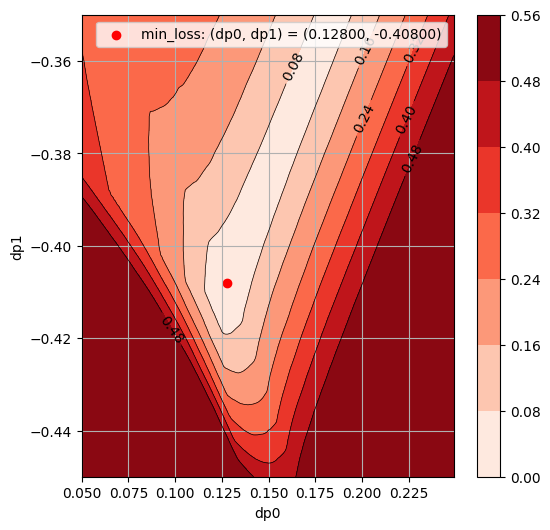

CV score: f1 = 0.38067738226844394


In [7]:
from sklearn.metrics import f1_score

# 解像度を1e-4, 1e-5と細かく実験したが精度向上にはつながらない
dp0_lst = np.arange(0.05, 0.25, 1e-3)
dp1_lst = np.arange(-0.45, -0.35, 1e-3)
# dp0_lst = np.arange(0.05, 0.25, 1e-3) # RandomForest
# dp1_lst = np.arange(-0.40, -0.30, 1e-3) # RandomForest

# F1スコア期待値が最大になる確率補正値を探索
dp0_opt, dp1_opt = threshold_tuning(oof_pred_df, dp0_lst, dp1_lst, weights_true)

# 予測確率を補正
dp_df = oof_pred_df.with_columns([pl.col("health_is_0") + dp0_opt, 
                                   pl.col("health_is_1") + dp1_opt, 
                                   pl.col("health_is_2") - dp0_opt - dp1_opt])

# スライドした閾値に基づくクラス分類
pred_label = np.argmax(dp_df, axis=1) 

# cv score
f1 = f1_score(np.array(train["health"]), pred_label, average="macro")
print("CV score: f1 =", f1)

### make submission file (Test)

In [8]:
# 判定閾値をナイーブベース(1/3, 1/3)からスライド
dp_df = test_pred_df.with_columns([pl.col("health_is_0") + dp0_opt, 
                                   pl.col("health_is_1") + dp1_opt, 
                                   pl.col("health_is_2") - dp0_opt - dp1_opt])

# スライドした閾値に基づくクラス分類
pred_label = np.argmax(dp_df, axis=1) 

# submission file
submission = pl.DataFrame({"idx": test["idx"], "PredictedLabel": pred_label})
submission.write_csv(f"submission_{clf_feat}.csv", include_header=False)

### visualize

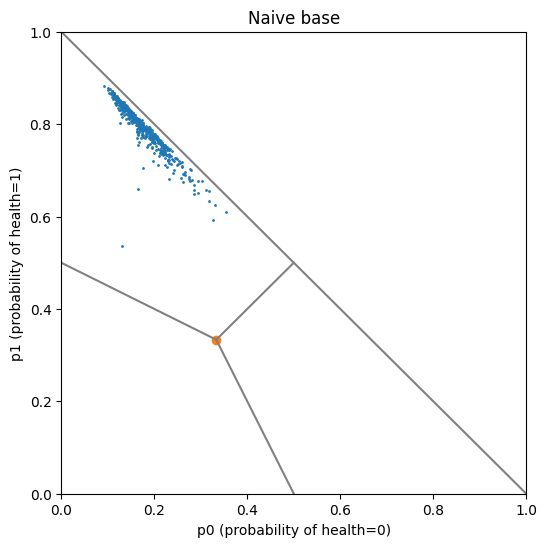

In [51]:
plt.figure(figsize=(6, 6))
plt.title("Naive base")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.scatter(oof_pred_df[:500, "health_is_0"].to_numpy(), oof_pred_df[:500, "health_is_1"].to_numpy(), s=1)
plt.xlabel("p0 (probability of health=0)")
plt.ylabel("p1 (probability of health=1)")
plt.plot([0, 1], [1, 0], c="gray")

plt.scatter(1/3, 1/3)
plt.plot([1/3, 1/2], [1/3, 0], c="gray")
plt.plot([1/3, 0], [1/3, 1/2], c="gray")
plt.plot([1/3, 1/2], [1/3, 1/2], c="gray")

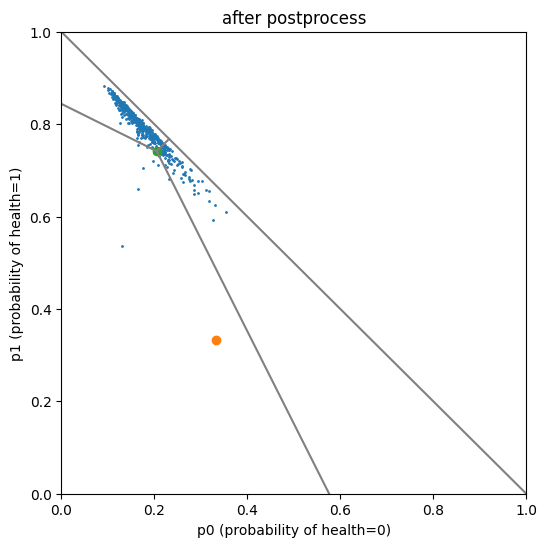

In [52]:
plt.figure(figsize=(6, 6))
plt.title("after postprocess")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.scatter(oof_pred_df[:500, "health_is_0"].to_numpy(), oof_pred_df[:500, "health_is_1"].to_numpy(), s=1)
plt.xlabel("p0 (probability of health=0)")
plt.ylabel("p1 (probability of health=1)")
plt.plot([0, 1], [1, 0], c="gray")

plt.scatter(1/3, 1/3)
plt.scatter(1/3 - dp0_opt, 1/3 - dp1_opt)
plt.plot([1/3 - dp0_opt, 1/2 - dp0_opt + 1], [1/3 - dp1_opt, 0 - dp1_opt - 2], c="gray")
plt.plot([1/3 - dp0_opt, 0 - dp0_opt], [1/3 - dp1_opt, 1/2 - dp1_opt], c="gray")
plt.plot([1/3 - dp0_opt, 1/2 - dp0_opt - 0.14], [1/3 - dp1_opt, 1/2 - dp1_opt - 0.14], c="gray")